# Workshop Tutorial: Optimizers

In this tutorial we will continue the fitting process by optimizing our results from the previous tutorial. 

Specifically we will cover:

- optimizer.nelder_mead

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Advanced: Nelder-Mead Optimizer](http://phoebe-project.org/docs/2.3/tutorials/nelder_mead)



In [1]:
import phoebe
from phoebe import u # units
import numpy as np
# Mac users may need to turn multi-processing off
#phoebe.multiprocessing_off() 
logger = phoebe.logger('error')

You may need to update the path below to where you saved the bundle from the previous tutorial, or you can download [after_estimators.bundle](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/after_estimators.bundle).

In [2]:
#Load Previous Bundle
b = phoebe.open('data/synthetic/after_estimators.bundle')

It's useful to remind ourselves what models and compute options we have in the bundle:

In [5]:
print(b.models, b.computes)

['rvgeom_model', 'ebai_model', 'lcgeom_model', 'latest'] ['phoebe01']


Now let's take a quick look at our final fit from the previous bundle:

100%|██████████| 200/200 [00:12<00:00, 15.69it/s]
/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


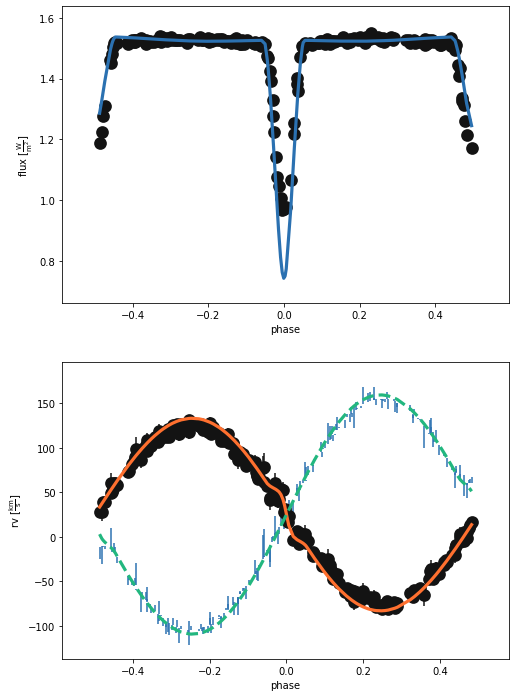

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [10]:
b.run_compute('phoebe01', model='after_estimators', overwrite=True)
b.plot(model='after_estimators', x='phases', show=True)

This looks close enough for the optimizer run. We will first initialize a new compute parameter-set and tweak a few optimization options for faster runtime:

In [12]:
b.add_compute(
    compute='nm_fit',
    irrad_method='none',
    rv_method='dynamical',
    distortion_method='sphere'
)

<ParameterSet: 40 parameters | datasets: _default, lc01, rv01>

To save even more time, we can run the optimizer in phase space instead of time space; for that, we need to provide an array of phases in which the model should be computed and optimized:

In [15]:
b.flip_constraint('compute_phases@rv01', solve_for='compute_times@rv01')
comp_phases = np.linspace(0,1,25)
b.set_value_all('compute_phases', dataset='rv01', value=comp_phases)

Phoebe has three optimizer methods: 

* conjugate gradient (`optimizer.cg`)
* powell (`optimizer.powell`) 
* nelder_mead (`optimizer.nelder_mead`) 

In most cases, `nelder_mead` is the most efficient so this is the one we will use moving forward. However, the logic is essentially identical if you would like to try a different one.

We start by adding an optimizer and attaching compute options to it:

In [16]:
b.add_solver('optimizer.nelder_mead',  solver='nm_solver', compute='nm_fit')

<ParameterSet: 14 parameters | qualifiers: fit_parameters, initial_values, priors, compute, expose_lnprobabilities, use_server, maxiter, xatol, fatol, priors_combine, progress_every_niters, comments, adaptive, continue_from>

Let's take a look at the parameters:

In [17]:
print(b['nm_solver'])

ParameterSet: 13 parameters
        comments@nm_solver@solver: 
      use_server@nm_solver@solver: compute
         compute@nm_solver@solver: nm_fit
   expose_lnprobabilities@nm_s...: False
   continue_from@nm_solver@solver: None
   fit_parameters@nm_solver@so...: []
   initial_values@nm_solver@so...: {}
          priors@nm_solver@solver: []
         maxiter@nm_solver@solver: 1000000
        adaptive@nm_solver@solver: False
           xatol@nm_solver@solver: 0.0001
           fatol@nm_solver@solver: 0.0001
   progress_every_niters@nm_so...: 0


For the tutorial we will reduce the maximum number of iterations to 20; let us also disable light curve data for now, in order to get radial velocity parameters figured out:

In [18]:
b.set_value('maxiter', solver='nm_solver', value=20)
b.disable_dataset('lc01')

<ParameterSet: 18 parameters | components: primary, binary, secondary>

Now we need to inform the optimizer which parameters should be adjusted:

In [19]:
b['fit_parameters@nm_solver'] = ['vgamma@system', 't0_supconj@binary', 'q@binary', 'asini@binary']

With everything set, we can now run the solver. This will take a little bit of time because of the non-zero eccentricity but not enough for a coffee run:

In [20]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


<ParameterSet: 11 parameters | qualifiers: fitted_values, success, adopt_distributions, initial_values, message, fitted_units, adopt_parameters, comments, fitted_twigs, niter, adopt_values>

New (fit) values for adjusted parameters are stored in the `fitted_values` parameter:

In [21]:
print(b['nm_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@nm_fit@nm_solu...: ['vgamma@system' 't0_supconj@binary@orbit@component'
 'q@binary@orbit@component' 'asini@binary@orbit@component']
   adopt_parameters@nm_fit@nm_...: ['vgamma@system', 't0_supconj@binary@orbit@component', 'q@binary@orbit@component', 'asini@binary@orbit@component']
   adopt_distributions@nm_fit@...: False
   adopt_values@nm_fit@nm_solu...: True
R    message@nm_solution@solution: Maximum number of iterations has been exceeded.
R      niter@nm_solution@solution: 20
R    success@nm_solution@solution: False
R  initial_values@nm_solution@...: [25.066195653764478 1.2333206527013554 0.8036935220296475
 8.008388359419728]
R  fitted_values@nm_fit@nm_sol...: [25.682312050990724 1.2204970293523285 0.7765393519102233
 7.939038913131434]
R  fitted_units@nm_fit@nm_solu...: ['km / s' 'd' '' 'solRad']
   comments@nm_fit@nm_solution...: 


Alternatively, we can call the `adopt_solution()` method by passing `trial_run=True`:

In [22]:
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 4 parameters
                    vgamma@system: 25.682312050990724 km / s
   t0_supconj@binary@orbit@com...: 1.2204970293523285 d
         q@binary@orbit@component: 0.7765393519102233
     asini@binary@orbit@component: 7.939038913131434 solRad


We can now run the model with these proposed parameters and inspect the solution visually:

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


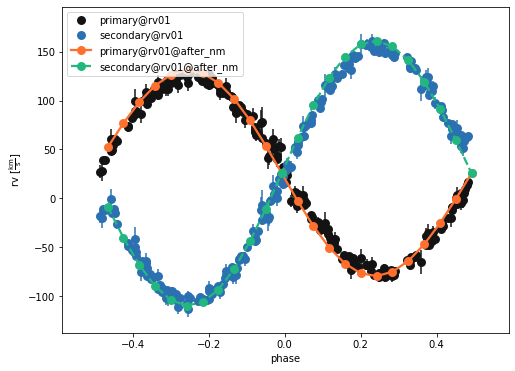

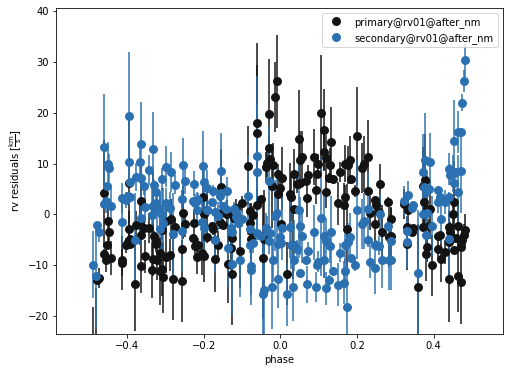

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [25]:
b.run_compute('nm_fit', solution='nm_solution', model='after_nm', overwrite=True)

b.plot(kind='rv', model='after_nm', x='phases', show=True, legend=True, marker = 'o')
b.plot( kind='rv', model='after_nm', x='phases', y='residuals', show=True, legend=True, marker = 'o')

This improves the initial fit, so we can adopt this solution, thus copying proposed solution values to the bundle's face values:

In [26]:
b.adopt_solution('nm_solution')

<ParameterSet: 22 parameters | contexts: system, component, dataset>

Now let's return to light curve data; enable them, and disable RVs:

In [27]:
b.disable_dataset('rv01')
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: primary, binary, secondary>

Depending on the number of data points, computing the forward model can take a long time. That means that _optimizing_ the model can take a _very_ long time. When light curve data do not exhibit significant out-of-eclipse variability, we can limit the optimizer to eclipse regions, thus saving us appreciable time. We will use our previous `lcgeom_solution` to mask out everything else. Eclipse regions are stored in the `eclipse_edges` parameter:

In [29]:
print(b['eclipse_edges@lcgeom_solution'])

Parameter: eclipse_edges@lcgeom_solution@solution
                       Qualifier: eclipse_edges
                     Description: detected phases of eclipse edges
                           Value: [-0.05580345  0.06513046 -0.5577     -0.43308724]
                  Constrained by: 
                      Constrains: None
                      Related to: None



The masking parameter is associated with the datasets:

In [38]:
print(b['mask_phases'])

ParameterSet: 2 parameters
         mask_phases@lc01@dataset: []
         mask_phases@rv01@dataset: []


To automatically populate these arrays, we will set `mask_phases` as a parameter to be adopted from the `lcgeom_solution` and then adopt the solution:

In [39]:
b.set_value(solution = 'lcgeom_solution', qualifier='adopt_parameters', value=['mask_phases'])
b.adopt_solution('lcgeom_solution')

<ParameterSet: 1 parameters>

Now the masked phases are populated by taking `eclipse_edges` and padding 30% of the eclipse width to ascertain adequate eclipse coverage:

In [41]:
print(b['mask_phases'])

ParameterSet: 2 parameters
         mask_phases@lc01@dataset: [[-0.09208362  0.10141063]
 [-0.59508383 -0.39570342]]
         mask_phases@rv01@dataset: []


The easiest way to see this in action is to visualize it:

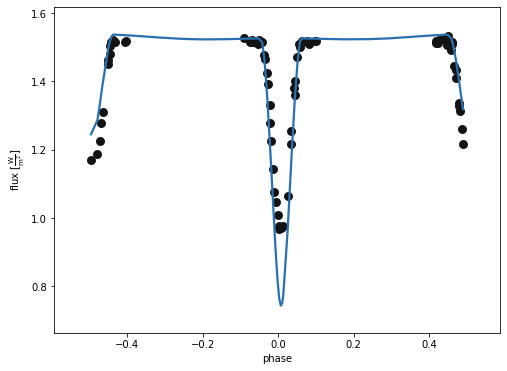

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [42]:
b.plot(kind='lc', model='after_estimators', x='phases', show='True')

Recall that, for estimators, we used $R_2/R_1$ and $R_1+R_2$ to parametrize the model. As we will run the actual forward model, it serves our purpose better to use $R_1$ and $R_2$ as independent parameters. Let us flip the constraint and mark relevant parameters for adjustment:

In [43]:
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary')

b['fit_parameters'] = [
    'teffratio@binary',
    't0_supconj@binary',
    'incl@binary'
]

As we set all solver parameters already, we can now simply run it:

In [44]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [05:00<00:00, 15.05s/it]


<ParameterSet: 11 parameters | qualifiers: fitted_values, success, adopt_distributions, initial_values, message, fitted_units, adopt_parameters, comments, fitted_twigs, niter, adopt_values>

As before, we can inspect the adjusted values either by looking at `fitted_values` or by running `adopt_solution()` with `trial_run=True`:

In [45]:
print(b.adopt_solution('nm_solution', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.90013042960959
   t0_supconj@binary@orbit@com...: 1.2352170911514588 d
      incl@binary@orbit@component: 83.25397704862235 deg


What did that do to our light curve fit?

100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


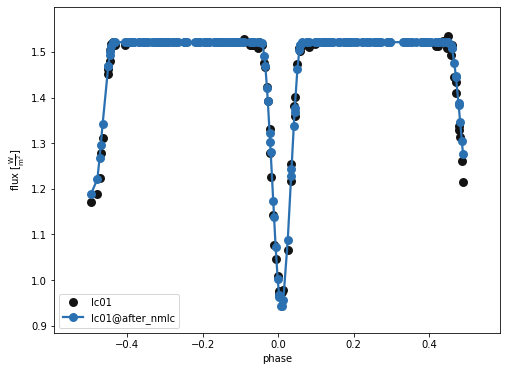

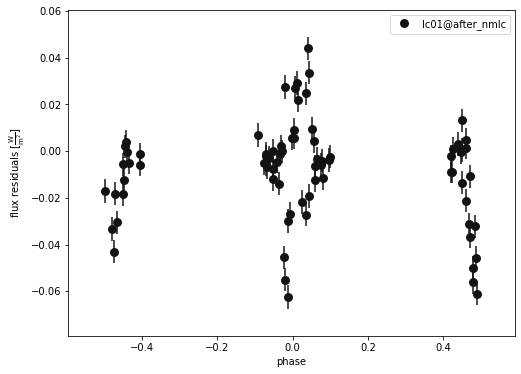

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [46]:
b.run_compute('nm_fit', solution='nm_solution', model='after_nmlc')

b.plot(kind='lc', model='after_nmlc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='after_nmlc', x='phases', y='residuals', show=True, legend=True, marker = 'o')

As before, this looks reasonable, so we can adopt the solution:

In [47]:
b.adopt_solution('nm_solution')

<ParameterSet: 24 parameters | contexts: component, dataset>

We can take a closer look at the primary eclipse:

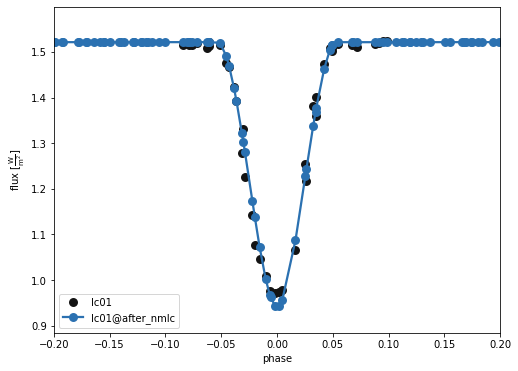

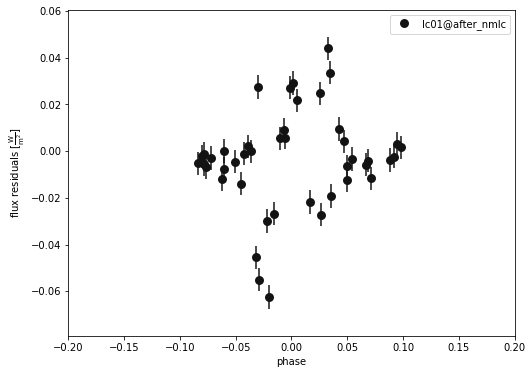

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [48]:
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

# Exercise

Combine both light and rv curves to achieve a better fit, primarily within the eclipse. Hint: It's often better to fit a small number of parameters first. 